In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

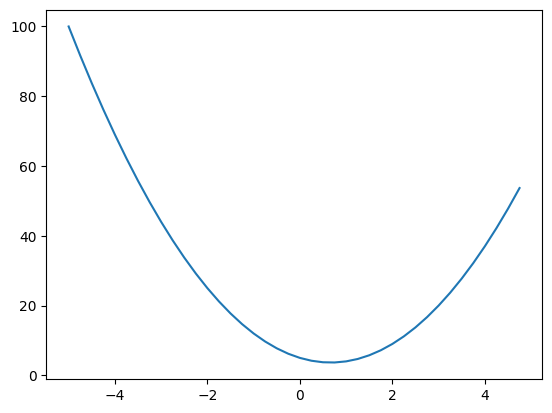

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001
x = -3.0
(f(x+h) - f(x) )/ h

-21.999700000066014

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [7]:
h = 0.001
a = 2.0
b = -3.0
c = 0

d1 = a*b +c
a +=h
d2 = a*b + c

In [8]:
print("d1", d1)
print("d2", d2)
print("slope", (d1-d2)/h)

d1 -6.0
d2 -6.003
slope 3.0000000000001137


In [66]:
class Value:
    def __init__(self, data, _children = (), _op = (), label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label=label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, _children = (self, other), _op = "+")
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children = (self, other), _op = "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    

    def exp(self):
        x = self.data
        out = Value(math.exp(x), _children=(self, ), _op = "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "Only power of int or float "
        out = Value(self.data ** other, _children=(self, ), _op = f"**{other}")
        def _backward():
            self.grad = other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [67]:
a = Value(2.0)
b = Value(4.0)

print(a / b)

Value(data=0.5)


In [68]:
from graphviz import Digraph

In [69]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

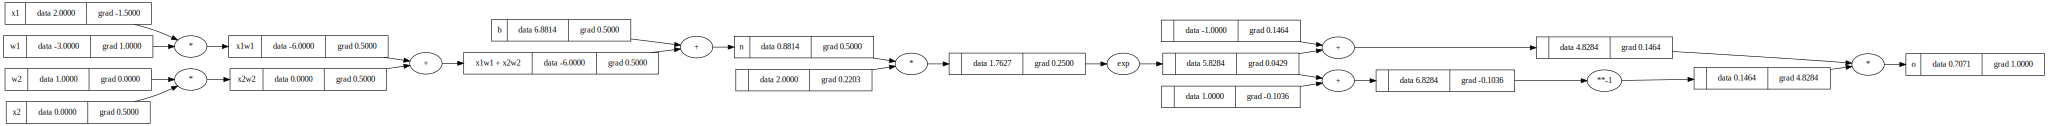

In [70]:
#inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label = "x2")
#weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.881373587019532, label = "b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
e = (2*n).exp()
o = (e - 1) / (e + 1) ; o.label = "o"

o.backward()
draw_dot(o)

In [59]:
o.backward()

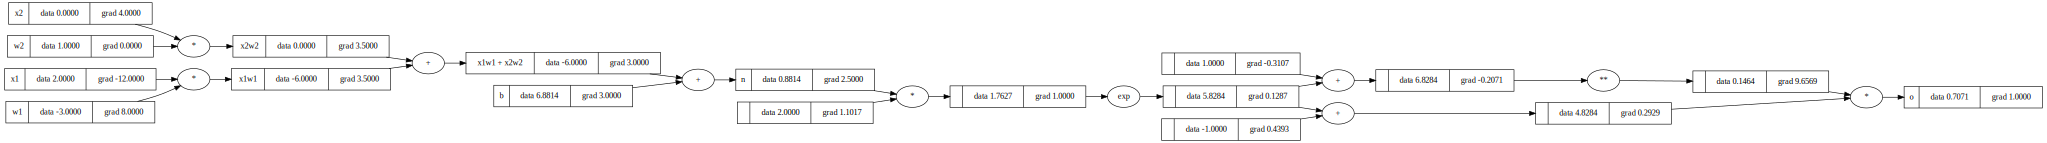

In [60]:
draw_dot(o)

In [ ]:
# https://youtu.be/VMj-3S1tku0?si=y7KieXN1o25RdMs2&t=6010